In [6]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *
from analysis import *

import sys
sys.path.append(constants.GRANTHAM_DISTANCE_PATH)

import grantham_distance as gd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [8]:
loaded = False

# Load BioBank Components

In [10]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    (biobank_data_no_HLA_alleles, biobank_index,
     med_code_mapping) = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    HLA_alleles = data_tools.load_HLA_data()
    biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 376 features.
UK BioBank Data Loaded.
Size: 502536 rows x 376 columns
Elapsed time: 50.8355 seconds


Mapping Medical Codes:   0%|          | 0/361 [00:00<?, ? feature/s]

# Conditions / Condition Search

In [163]:
autoimmune_conditions = ["type 1 diabetes", "rheumatoid arthritis",
                         "psoriasis", "asthma", "multiple sclerosis", "systemic lupus erythematosis/sle",
                         "inflammatory bowel disease", "grave's disease", "hypothyroidism/myxoedema",
                         "hyperthyroidism/thyrotoxicosis", "myasthenia gravis", "pernicious anaemia",
                         "sjogren's syndrome/sicca syndrome", "eczema/dermatitis",
                         'acute infective polyneuritis/guillain-barre syndrome', "malabsorption/coeliac disease",
                        ]

psychiatric_conditions = ["schizophrenia", "depression", "mania/bipolar disorder/manic depression",
                          "obsessive compulsive disorder (ocd)", "anxiety/panic attacks",
                          "alcohol dependency"]

other_conditions = ["vasculitis", "hypertension"]
neurological_conditions = ["epilepsy"]

HLA_dosing_conditions = {"psychiatric": psychiatric_conditions, "autoimmune": autoimmune_conditions, 
                         "other": other_conditions}

data_tools.biobank_search(med_code_mapping, biobank_data, ('sepsis'))

,coding,meaning,code_format,name,count
448,1657,septicaemia / sepsis,6,illness_code,66
7217,77149,77149 Omphalitis of newborn (other and unspeci...,87,cancer_type_ICD9,0
7236,77180,77180 Intrauterine congenital sepsis,87,cancer_type_ICD9,0
11088,O85,O85 Puerperal sepsis,19,cancer_type_ICD10,0
11358,P36,P36 Bacterial sepsis of newborn,19,cancer_type_ICD10,0
11359,P360,P36.0 Sepsis of newborn due to streptococcus; ...,19,cancer_type_ICD10,0
11360,P361,P36.1 Sepsis of newborn due to other and unspe...,19,cancer_type_ICD10,0
11361,P362,P36.2 Sepsis of newborn due to Staphylococcus ...,19,cancer_type_ICD10,0
11362,P363,P36.3 Sepsis of newborn due to other and unspe...,19,cancer_type_ICD10,0
11363,P364,P36.4 Sepsis of newborn due to Escherichia coli,19,cancer_type_ICD10,0


In [12]:
illness_codes = [feature for feature in biobank_data.columns if get_base_feature(feature) == "illness_code"]
all_illnesses = biobank_data[illness_codes].values.ravel()
all_illnesses, counts = np.unique(all_illnesses[~pd.isnull(all_illnesses)], return_counts=True)
all_illnesses = all_illnesses[counts > 30]

In [13]:
values = []
exposure_feature = "zygosity"
exposure_baseline = None

exposure = biobank_data[exposure_feature].values
exposure_values, counts = np.unique(exposure[~np.isnan(exposure)], return_counts=True)

if exposure_baseline is None or exposure_baseline not in exposure_values:
    exposure_baseline = exposure_values[np.argmax(counts)]

non_baseline_exposure_values = [value for value in exposure_values if value != exposure_baseline]

values = []
for illness in psychiatric_conditions:
    illness_value = get_illness_value(biobank_data, illness, "illness_code")
    illness_label = f"{illness} ({exposure_feature} != {exposure_baseline})"
    values.append([illness_label, *calculate_OR(illness_value, exposure != exposure_baseline)[:3]])
    for value in non_baseline_exposure_values:
        illness_label = f"{illness} ({exposure_feature} == {value})"
        values.append([illness_label, *calculate_OR(illness_value, exposure == value)[:3]])
        
columns = ["illness", "OR", "p-value", "N"]
df = pd.DataFrame(values, columns=columns)
df["significant"] = df["p-value"] < .07
df

,illness,OR,p-value,N,significant
0,schizophrenia (zygosity != 0.0),1.033909,0.709948,158,False
1,schizophrenia (zygosity == 1.0),0.882405,0.311909,84,False
2,schizophrenia (zygosity == 2.0),0.726025,0.169844,20,False
3,schizophrenia (zygosity == 3.0),1.335160,0.200737,21,False
4,depression (zygosity != 0.0),0.978771,0.133224,6928,False
5,depression (zygosity == 1.0),0.997014,0.870924,4257,False
6,depression (zygosity == 2.0),0.991268,0.788024,1232,False
7,depression (zygosity == 3.0),1.079494,0.043897,777,True
8,mania/bipolar disorder/manic depression (zygos...,0.966600,0.600523,343,False
9,mania/bipolar disorder/manic depression (zygos...,0.975452,0.766060,209,False


In [170]:
clinical_mono_label = 'infectious mononucleosis / glandular fever / epstein barr virus (ebv)'
hiv_label = "hiv/aids"
hepatitis_label = "infective/viral hepatitis"

biobank_data["clinical_mononucleosis"] = get_illness_value(biobank_data, illness=clinical_mono_label,
                                                           base_feature="illness_code")

biobank_data["HIV/AIDS"] = get_illness_value(biobank_data, illness=hiv_label, base_feature="illness_code")
biobank_data["hepatitis"] = get_illness_value(biobank_data, illness=hepatitis_label, base_feature="illness_code")
biobank_data["pneumonia"] = get_illness_value(biobank_data, illness="pneumonia", base_feature="illness_code")
biobank_data["sepsis"] = get_illness_value(biobank_data, illness="septicaemia / sepsis", base_feature="illness_code")

biobank_data["known_infection"] = biobank_data[["hepatitis", "clinical_mononucleosis", "pneumonia", "sepsis"]].sum(axis=1) != 0

In [171]:
data = biobank_data

for illness in autoimmune_conditions:
    print(illness.upper())
    illness_values = get_illness_value(data, illness, "illness_code")
    text = ""
    for variable in ["sex", "zygosity", "clinical_mononucleosis", "HIV/AIDS", "hepatitis",
                     "pneumonia", "sepsis", "known_infection"]:
        line = variable_OR_test(illness=illness_values, variable=variable, CI=None, data=data)
        if not line.endswith("N: 0\n"):
            text += line
    print("\t" + text.replace('\n', '\n\t'))

TYPE 1 DIABETES
	sex == Male: OR: 1.140 p-value: 0.179 N: 214
	zygosity != 0.0: OR: 1.323 p-value: 0.012 N: 118 ***
	zygosity == 1.0: OR: 1.138 p-value: 0.313 N: 73
	zygosity == 2.0: OR: 1.106 p-value: 0.638 N: 21
	zygosity == 3.0: OR: 2.229 p-value: 0.001 N: 24 ***
	hepatitis == True: OR: 2.082 p-value: 0.251 N: 2
	pneumonia == True: OR: 2.024 p-value: 0.022 N: 12 ***
	known_infection == True: OR: 1.859 p-value: 0.028 N: 14 ***
	
RHEUMATOID ARTHRITIS
	sex == Male: OR: 0.511 p-value: 5.8e-126 N: 1,706 ***
	zygosity != 0.0: OR: 1.041 p-value: 0.212 N: 1,284
	zygosity == 1.0: OR: 1.099 p-value: 0.010 N: 922 ***
	zygosity == 2.0: OR: 0.881 p-value: 0.067 N: 220
	zygosity == 3.0: OR: 0.981 p-value: 0.865 N: 142
	clinical_mononucleosis == True: OR: 1.056 p-value: 0.843 N: 7
	HIV/AIDS == True: OR: 0.942 p-value: 1.000 N: 5
	hepatitis == True: OR: 1.045 p-value: 0.776 N: 13
	pneumonia == True: OR: 1.336 p-value: 0.006 N: 103 ***
	sepsis == True: OR: 1.812 p-value: 0.156 N: 6
	known_infection 

In [174]:
EBV_associated = ["sjogren's syndrome/sicca syndrome", 'eczema/dermatitis',
                  'acute infective polyneuritis/guillain-barre syndrome', 'malabsorption/coeliac disease']

illness_values = np.zeros(len(data))
for illness in EBV_associated:
    illness_values = illness_values | get_illness_value(data, illness, "illness_code")

text = ""
for variable in ["sex", "zygosity", "clinical_mononucleosis", "HIV/AIDS", "hepatitis",
                     "pneumonia", "sepsis", "known_infection"]:
    text += variable_OR_test(illness=illness_values, variable=variable, CI=None, data=data)
print(text)

sex == Male: OR: 0.860 p-value: 1.3e-19 N: 6,361 ***
zygosity != 0.0: OR: 1.061 p-value: 0.003 N: 3,528 ***
zygosity == 1.0: OR: 0.968 p-value: 0.161 N: 2,250
zygosity == 2.0: OR: 1.108 p-value: 0.009 N: 739 ***
zygosity == 3.0: OR: 1.405 p-value: 4.5e-13 N: 539 ***
clinical_mononucleosis == True: OR: 1.607 p-value: 0.021 N: 28 ***
HIV/AIDS == True: OR: 0.913 p-value: 0.893 N: 13
hepatitis == True: OR: 1.429 p-value: 0.022 N: 47 ***
pneumonia == True: OR: 1.576 p-value: 1.7e-13 N: 320 ***
sepsis == True: OR: 1.238 p-value: 0.493 N: 11
known_infection == True: OR: 1.534 p-value: 9.7e-15 N: 396 ***



'ECZEMA/DERMATITIS'

# Grantham Distance

Making OR Plots:   0%|          | 0/6 [00:00<?, ? plot/s]

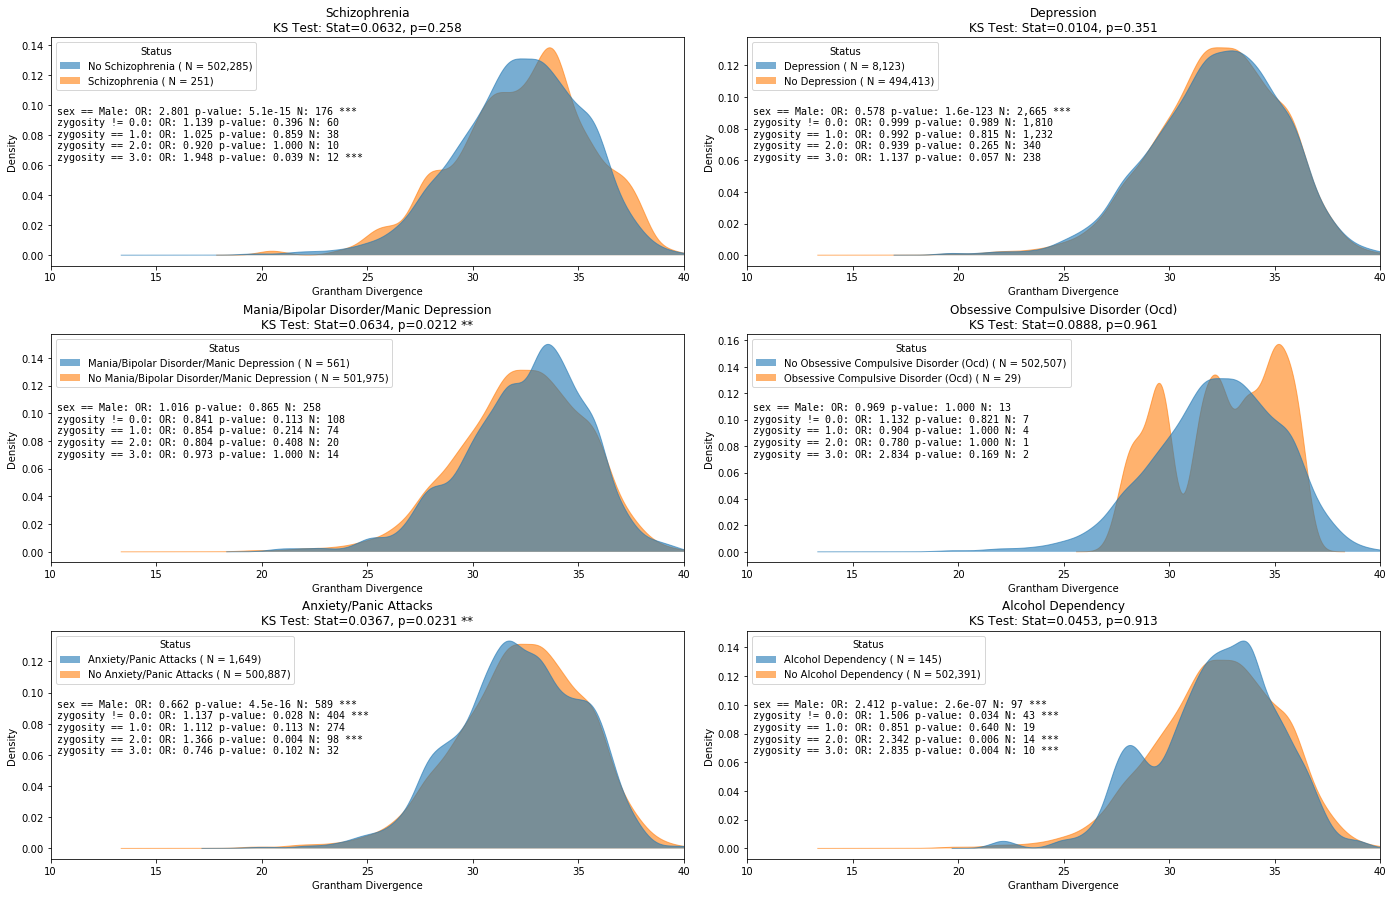

In [17]:
condition = "psychiatric"
x = "grantham_divergence"
OR_variables = ["sex", "zygosity"]
conditions = HLA_dosing_conditions[condition]

big_fig, big_axes = create_subplot(len(conditions), width=20, height_per=3.5, ncols=2, wspace=.1, hspace=.3)
for illness, big_ax in tqdm(zip(conditions, big_axes), unit=" plot", desc="Making OR Plots",
                            total=len(big_axes)):

    fig, ax = variable_OR_plot(biobank_data, illness, "illness_code", x=x, OR_variable=OR_variables)
    save_name = illness.replace(" ", "_").replace("/", "_").replace("'", "")
    fig.savefig(f"illness_EDA_plots/grantham_distance_plots/{condition}/{save_name}.png")
    plt.close()
    variable_OR_plot(biobank_data, illness, "illness_code", x=x, OR_variable=OR_variables, ax=big_ax)
    big_ax.set_xlim(10, 40)
    
big_fig.savefig(f"illness_EDA_plots/grantham_distance_plots/{condition}/multiple_HLA_grantham_distance.png")

# All Illnesses Exploration

In [21]:
report = ""
for i, illness in enumerate(tqdm(all_illnesses)):
    report += illness.upper() + '\n\t'
    illness_values = get_illness_value(biobank_data, illness, "illness_code")
    report += variable_OR_test(illness=illness_values, variable="zygosity", CI=None,
                               data=biobank_data).replace('\n', '\n\t')
    report += '\n'
    if i > 3:
        break

print(report)

  0%|          | 0/413 [00:00<?, ?it/s]

ABDOMINAL HERNIA
	zygosity != 0.0: OR: 1.029 p-value: 0.840 N: 73
	zygosity == 1.0: OR: 1.177 p-value: 0.275 N: 56
	zygosity == 2.0: OR: 0.622 p-value: 0.175 N: 9
	zygosity == 3.0: OR: 0.963 p-value: 1.000 N: 8
	
ABNORMAL SMEAR (CERVIX)
	zygosity != 0.0: OR: 0.977 p-value: 0.820 N: 153
	zygosity == 1.0: OR: 1.004 p-value: 0.958 N: 107
	zygosity == 2.0: OR: 0.931 p-value: 0.783 N: 29
	zygosity == 3.0: OR: 0.937 p-value: 0.905 N: 17
	
ACNE/ACNE VULGARIS
	zygosity != 0.0: OR: 0.945 p-value: 0.728 N: 64
	zygosity == 1.0: OR: 0.954 p-value: 0.872 N: 44
	zygosity == 2.0: OR: 1.133 p-value: 0.575 N: 15
	zygosity == 3.0: OR: 0.637 p-value: 0.463 N: 5
	
ACROMEGALY
	zygosity != 0.0: OR: 0.799 p-value: 0.550 N: 12
	zygosity == 1.0: OR: 0.789 p-value: 0.727 N: 8
	zygosity == 2.0: OR: 1.054 p-value: 0.763 N: 3
	zygosity == 3.0: OR: 0.594 p-value: 1.000 N: 1
	
ACUTE INFECTIVE POLYNEURITIS/GUILLAIN-BARRE SYNDROME
	zygosity != 0.0: OR: 0.779 p-value: 0.197 N: 36
	zygosity == 1.0: OR: 0.807 p-value: 0.

In [20]:
values = []
exposure_feature = "zygosity"
exposure_baseline = None

exposure = biobank_data[exposure_feature].values
exposure_values, counts = np.unique(exposure[~np.isnan(exposure)], return_counts=True)

if exposure_baseline is None or exposure_baseline not in exposure_values:
    exposure_baseline = exposure_values[np.argmax(counts)]

non_baseline_exposure_values = [value for value in exposure_values if value != exposure_baseline]

values = []
for illness in tqdm(all_illnesses):
    illness_value = get_illness_value(biobank_data, illness, "illness_code")
    values.append([illness, f"{exposure_feature} != {exposure_baseline}",
                   *calculate_OR(illness_value, exposure != exposure_baseline, CI=None)[:3]])
    for value in non_baseline_exposure_values:
        values.append([illness, f"{exposure_feature} == {value}",
                       *calculate_OR(illness_value, exposure == value, CI=None)[:3]])

        
columns = ["illness", "exposure", "OR", "p-value", "N"]
df = pd.DataFrame(values, columns=columns)
df["significant"] = df["p-value"] < .07
df.head()

  0%|          | 0/413 [00:00<?, ?it/s]

,illness,exposure,OR,p-value,N,significant
0,abdominal hernia,zygosity != 0.0,1.049158,0.700607,84,False
1,abdominal hernia,zygosity == 1.0,1.168089,0.278967,56,False
2,abdominal hernia,zygosity == 2.0,0.618325,0.175474,9,False
3,abdominal hernia,zygosity == 3.0,0.957480,1.000000,8,False
4,abnormal smear (cervix),zygosity != 0.0,0.956122,0.631094,169,False


zygosity != 0.0


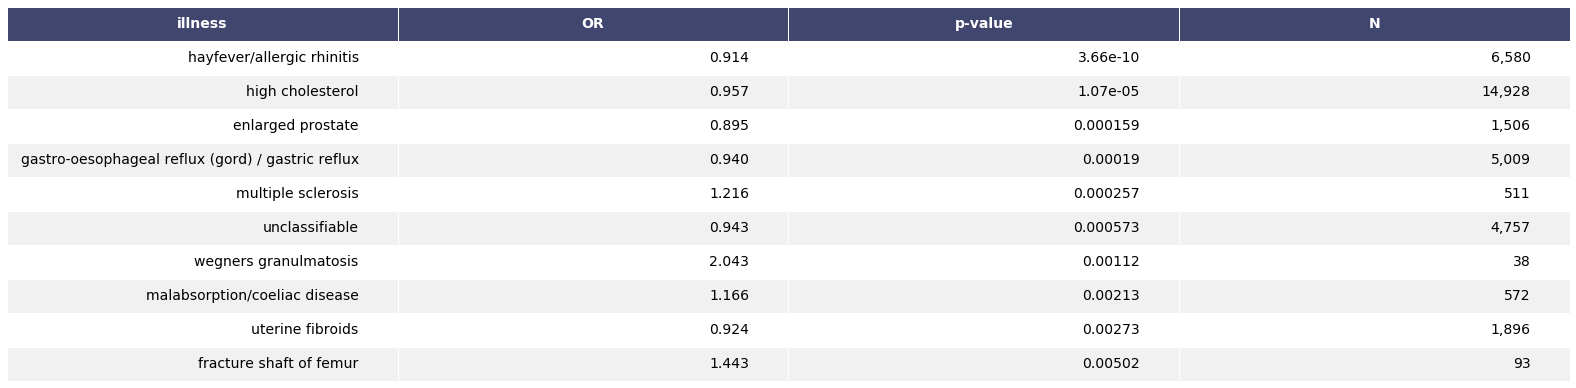

zygosity == 1.0


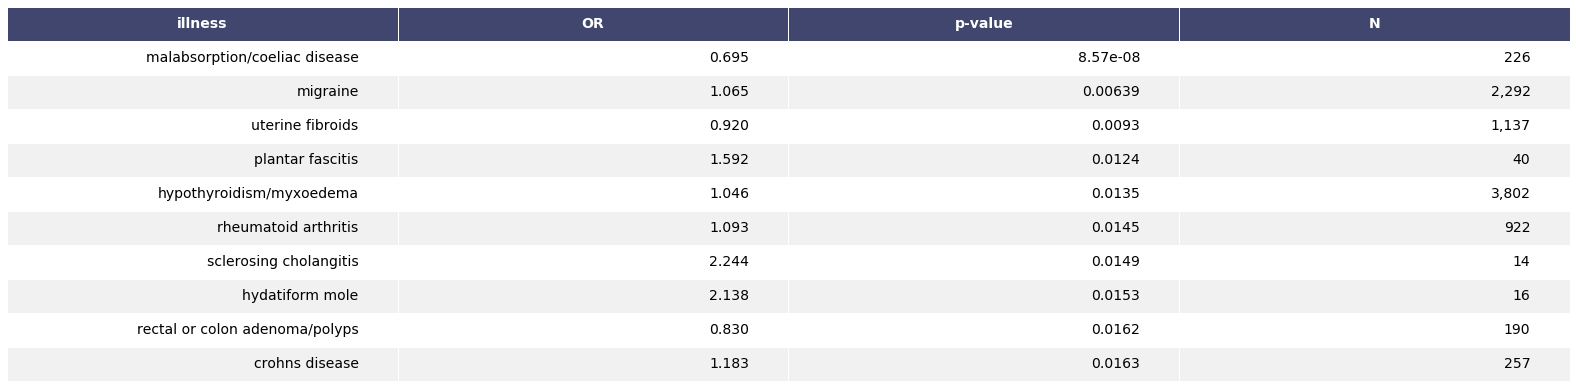

zygosity == 2.0


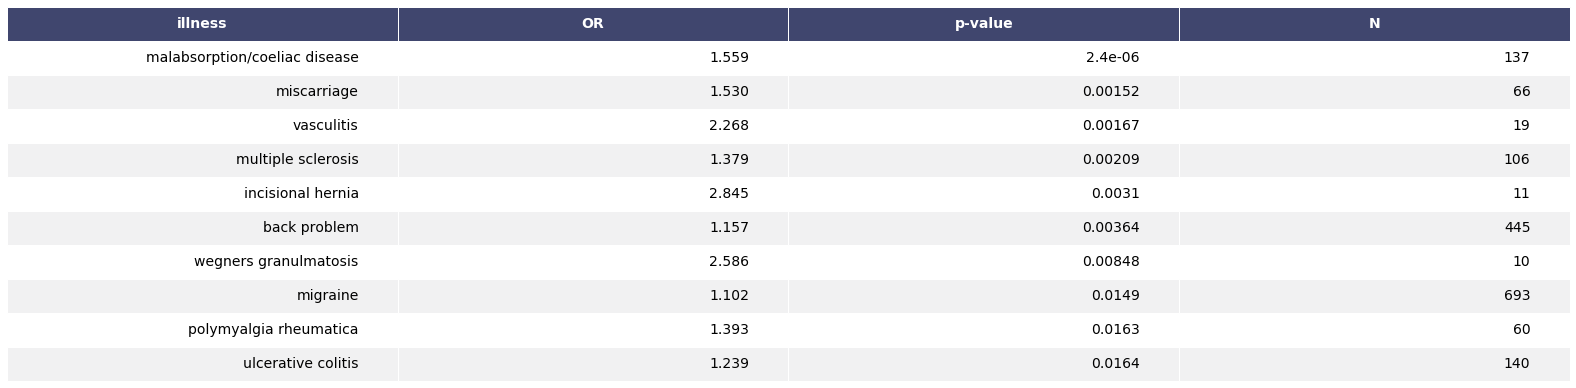

zygosity == 3.0


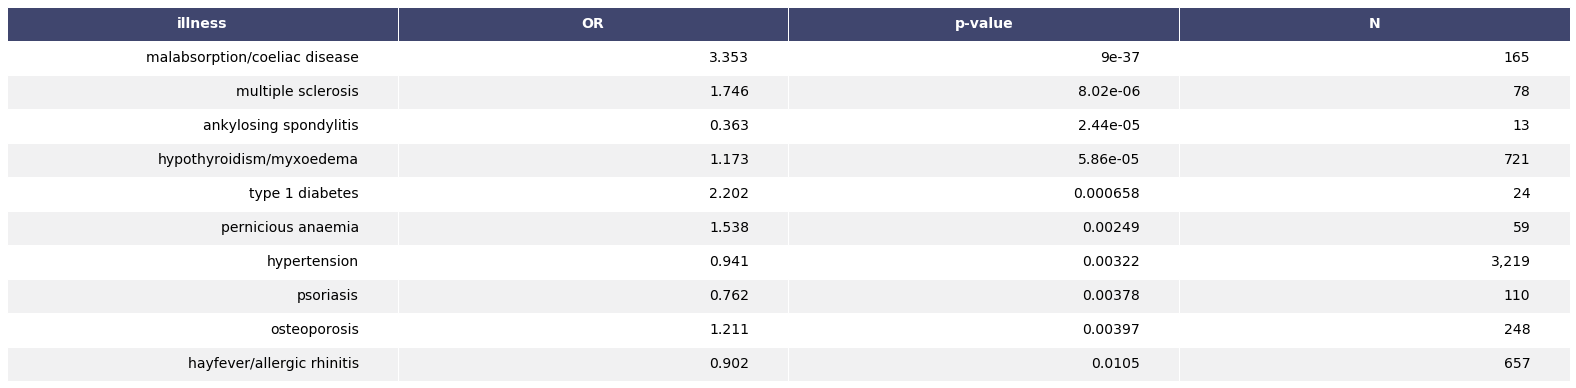

In [22]:
for exposure in sorted(df["exposure"].unique()):
    print(exposure)
    table = df.query(f"exposure == '{exposure}'").query("N > 3").sort_values("p-value").head(10)
    table["OR"] = table["OR"].apply(lambda s: f"{s:.3f}")
    table["p-value"] = table["p-value"].apply(lambda s: f"{s:.3}")
    table["N"] = table["N"].apply(lambda s: f"{s:,.0f}")
    fig, ax = render_mpl_table(table.drop(columns=["significant", "exposure"]), col_width=7)
    plt.show()

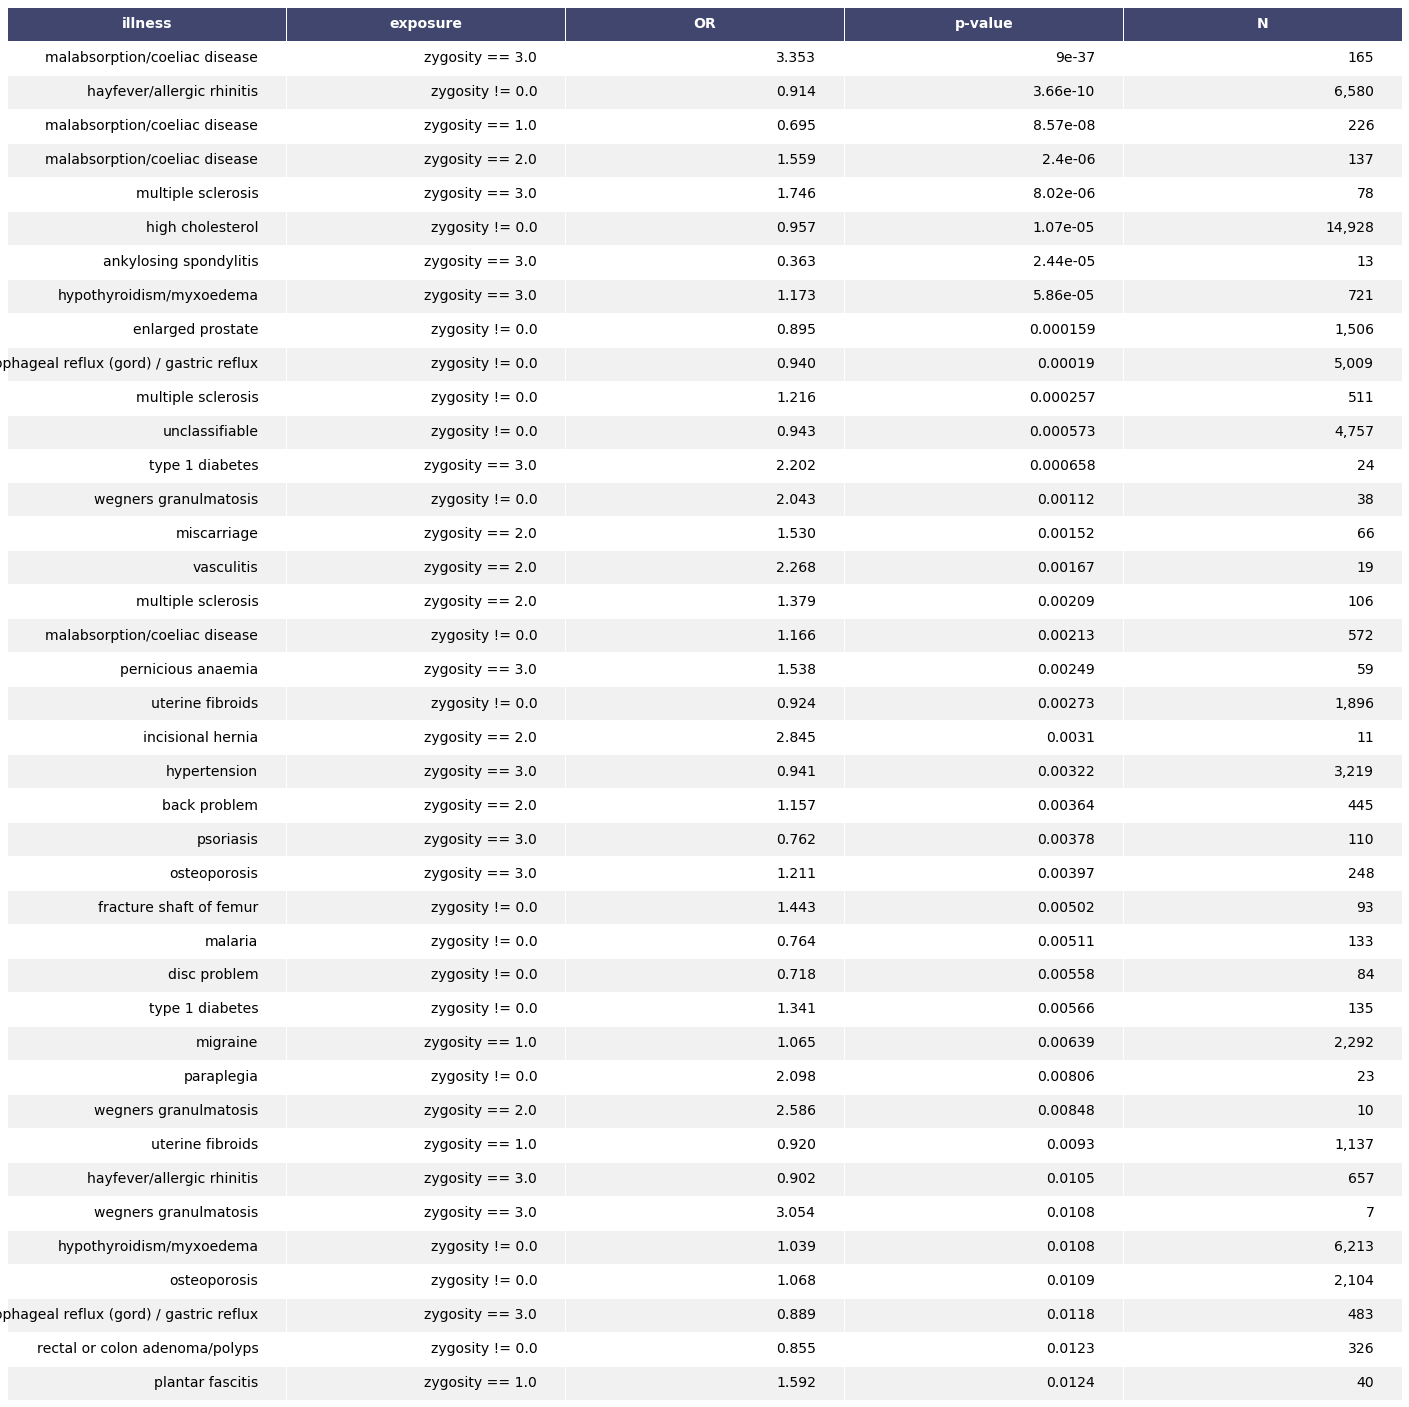

In [23]:
table = df.query("N > 3").sort_values("p-value").head(40)
table["OR"] = table["OR"].apply(lambda s: f"{s:.3f}")
table["p-value"] = table["p-value"].apply(lambda s: f"{s:.3}")
table["N"] = table["N"].apply(lambda s: f"{s:,.0f}")
fig, ax = render_mpl_table(table.drop(columns=["significant"]), col_width=5)

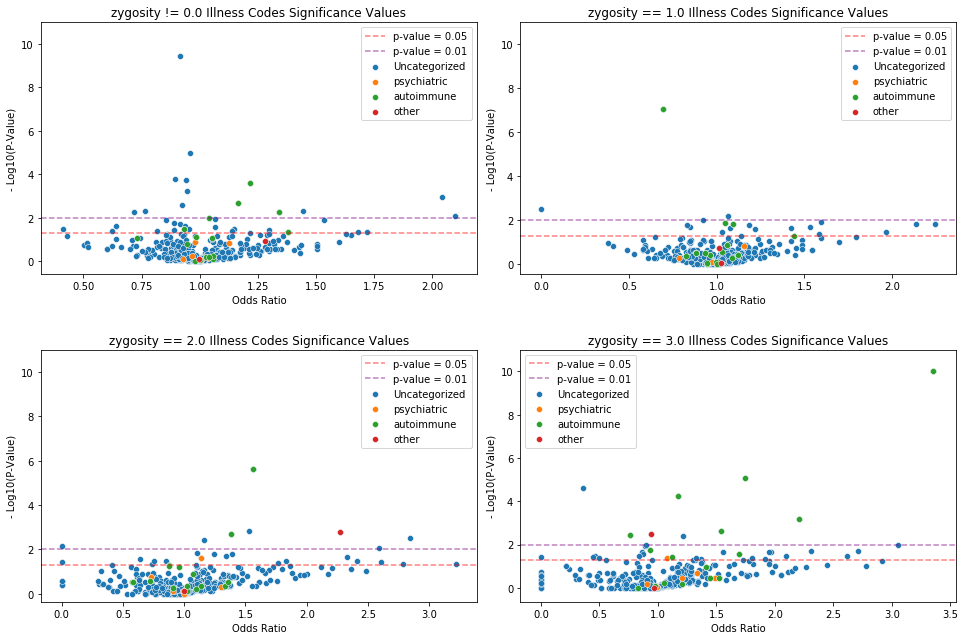

In [59]:
exposures = sorted(df["exposure"].unique())
fig, axes = create_subplot(len(exposures), width=14, height_per=3.5, ncols=2, wspace=.1, hspace=.3)

for exposure, ax in zip(exposures, axes):
    data = df.query(f"exposure == '{exposure}'").copy(deep=True)
    data["p-value"] = np.clip(-np.log10(data["p-value"]), 0, 10)

    sns.scatterplot(data=data, x="OR", y="p-value", ax=ax, label="Uncategorized", zorder=-1)
    for condition_set, conditions in HLA_dosing_conditions.items():
        condition_indices = data["illness"].isin(conditions)
        uncategorized = uncategorized | condition_indices 
        category_data = data.loc[condition_indices]
        sns.scatterplot(data=category_data, x="OR", y="p-value", ax=ax, label=condition_set)
        
    ax.axhline(-np.log10(.05), linestyle="--", color="r", label="p-value = 0.05", alpha=.5)
    ax.axhline(-np.log10(.01), linestyle="--", color="purple", label="p-value = 0.01", alpha=.5)
    ax.legend()
    ax.set_xlabel("Odds Ratio")
    ax.set_ylabel("- Log10(P-Value)")
    ax.set_title(f"{exposure} Illness Codes Significance Values")
    ax.set_ylim(None, 11)
plt.show()

# Specific HLA GWAS

In [254]:
illness = "multiple sclerosis"
illness = 'hodgkins lymphoma / hodgkins disease'
illness = 'nasal cavity cancer'

HLA_allele_columns = ["A1", "A2", "B1", "B2", "C1", "C2"]

illness_values = get_illness_value(biobank_data, illness, "cancer_code")
illness_data, control_data = biobank_data.loc[illness_values], biobank_data.loc[~illness_values]

illness_alleles = illness_data[HLA_allele_columns].values.ravel()
illness_alleles = np.unique(illness_alleles[~pd.isnull(illness_alleles)])

In [255]:
text = ""
data = []
for allele in tqdm(illness_alleles):
    allele_loc_cols = [allele[0] + f"{i}" for i in [1, 2]]
    all_allele_zygosity = np.sum(biobank_data[allele_loc_cols] == allele, axis=1)

    odds_ratio, p_value, N, lower_bound, upper_bound = calculate_OR(illness_values, all_allele_zygosity != 0)
    
    data.append([allele, odds_ratio, p_value, N, lower_bound, upper_bound])

    p_value_str = f"{p_value:.2}" if "e" in str(p_value) else f"{p_value:.3f}"
    line = f"{allele}: OR: {odds_ratio:.3f} p-value: {p_value_str}"
    line += f" 95% CI: {lower_bound:.2f} - {upper_bound:.2f}"
    line += f" N: {N:,}"
    line += "\n" if p_value > .05 else " ***\n"
    text += line
data = pd.DataFrame(data, columns=["allele", "odds_ratio", "p_value", "N", "lower_bound", "upper_bound"])

  0%|          | 0/56 [00:00<?, ?it/s]

In [256]:
data["hla_loci"] = data["allele"].apply(lambda s: s[0])

In [257]:
data.query("p_value < .05 and N > 5").sort_values(["odds_ratio"])

,allele,odds_ratio,p_value,N,lower_bound,upper_bound,hla_loci
28,B*44:02,1.876818,0.045549,15,1.124499,3.132457,B
45,C*05:01,2.055006,0.026767,16,1.241864,3.400575,C


In [258]:
EBV_protective_alleles = ['A*02:01', 'B*44:02', 'C*07:01']
EBV_risk_alleles = ['A*31:01', 'B*13:02', 'B*40:01', 'C*03:04', 'C*06:02']

protective_zygosity = biobank_data[HLA_allele_columns].isin(EBV_protective_alleles).sum(axis=1)
risk_zygosity = biobank_data[HLA_allele_columns].isin(EBV_risk_alleles).sum(axis=1)

In [265]:
calculate_OR(illness_values, protective_zygosity > 3)

(2.781143861018934,
 0.306424658880862,
 1,
 0.5274967345408418,
 14.663145132862306)

(array([3.3551369 , 0.        , 0.        , 0.        , 0.        ,
        1.47003848, 0.        , 0.        , 0.        , 0.17482462]),
 array([0.25, 0.45, 0.65, 0.85, 1.05, 1.25, 1.45, 1.65, 1.85, 2.05, 2.25]),
 <a list of 10 Patch objects>)

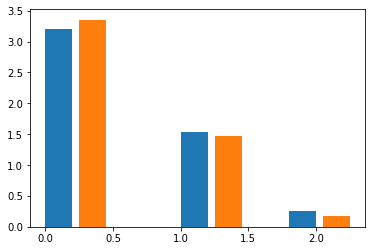

In [107]:
plt.hist(allele_zygosity, density=True)
plt.hist(control_allele_zygosity + .25, density=True)

# Experiment: Creating an HLA linkage map using grantham distance

In [60]:
class_I_allele_map = gd.HLAAlleleSequenceMapping(gd.HLA_CLASS_I_ALLELE_AMINO_ACID_SEQUENCES_ABS_PATH)

In [61]:
print(autoimmune_conditions)
illness = autoimmune_conditions[4]
illness_name = titleize(illness.replace("malabsorption/", "").replace("coeliac", "celiac"))
illness

['type 1 diabetes', 'rheumatoid arthritis', 'psoriasis', 'asthma', 'multiple sclerosis', 'systemic lupus erythematosis/sle', 'inflammatory bowel disease', "grave's disease", 'hypothyroidism/myxoedema', 'hyperthyroidism/thyrotoxicosis', 'myasthenia gravis', 'pernicious anaemia', "sjogren's syndrome/sicca syndrome", 'eczema/dermatitis', 'acute infective polyneuritis/guillain-barre syndrome', 'malabsorption/coeliac disease']


'multiple sclerosis'

In [64]:
HLA_allele_columns = ["A1", "A2", "B1", "B2", "C1", "C2"]
HLA_allele_sequence_columns = []

illness_values = get_illness_value(biobank_data, illness, "illness_code")
illness_data = biobank_data.loc[illness_values].dropna(subset=HLA_allele_columns)
control_data = biobank_data.loc[~illness_values].dropna(subset=HLA_allele_columns).sample(len(illness_data))

data = pd.concat([illness_data, control_data]).copy(deep=True)
data["illness"] = np.hstack([[illness_name] * len(illness_data), [f"No {illness_name}"] * len(control_data)])
data["illness_value"] = np.hstack([[1] * len(illness_data), [0] * len(control_data)])
print(len(illness_data))

for allele_column in HLA_allele_columns:
    data[f"{allele_column}_sequence"] = data[allele_column].apply(class_I_allele_map._map, None)
    HLA_allele_sequence_columns.append(f"{allele_column}_sequence")
data = data.dropna(subset=HLA_allele_sequence_columns)

1703


In [65]:
n_max = 1000

linkage_data = data.sample(n_max) if len(data) > n_max else data
linkage_data = linkage_data.sort_values("illness_value")
linkage_data["zygosity"] = linkage_data["zygosity"].apply(int)

HLA_dict = dict(zip(linkage_data["eid"], linkage_data[HLA_allele_sequence_columns].values))

In [66]:
def create_grantham_linkage_map(HLA_dict: dict) -> np.ndarray:
    """"""
    linkage_map = np.zeros((len(HLA_dict), len(HLA_dict)))

    pbar = tqdm(total=len(HLA_dict) ** 2 // 2, unit=" grantham linkage", desc="Creating Grantham Linkage Map")
    p2s = list(HLA_dict.values())
    N = len(p2s)
    for i, p1 in enumerate(HLA_dict.values()):
        for j in range(i, N):
            linkage_map[i, j] = memoized_grantham_linkage._call(p1, p2s[j])
        pbar.update(N - i)

    i_lower = np.tril_indices(N, -1)
    linkage_map[i_lower] = linkage_map.T[i_lower]
    return linkage_map

linkage_map = create_grantham_linkage_map(HLA_dict)

Creating Grantham Linkage Map:   0%|          | 0/500000 [00:00<?, ? grantham linkage/s]

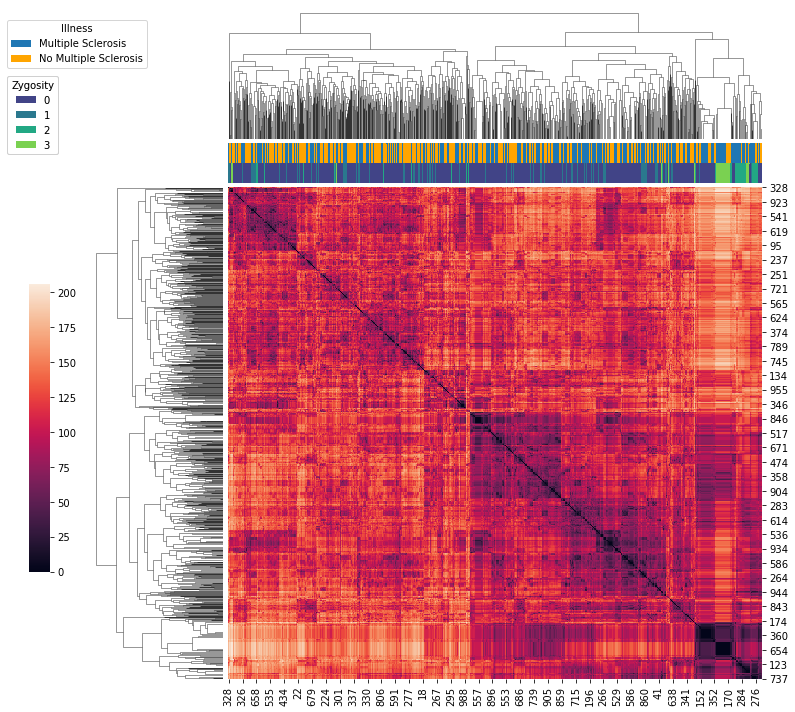

In [67]:
luts = {}
palettes = [["C0", "orange"], sns.color_palette("viridis", 4)]
variables = ["illness", "zygosity"]

col_colors = []
for variable, palette in zip(variables, palettes):
    luts[variable] = dict(zip(set(linkage_data[variable]), palette))
    col_colors.append(linkage_data[variable].map(luts[variable]).values)
    
g = sns.clustermap(linkage_map, col_colors=col_colors, cbar_pos=(-.07, .2, .03, .4))

from matplotlib.patches import Patch


i = 0
legends = []
for variable, lut in luts.items():
    handles = [g.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0) for label in lut]
    l = plt.legend(handles, lut, title=titleize(variable), bbox_transform=plt.gcf().transFigure,
               bbox_to_anchor=(-.1, .9 - i / 400), loc=(0, 0))
    g.fig.canvas.draw()
    i += l.get_frame().get_bbox().height
    legends.append(l)

for l_i in legends:
    plt.gca().add_artist(l_i)

illness_save_name = illness_name.replace("/", "_").replace(" ", "_").lower()
g.savefig(f"illness_EDA_plots/grantham_distance_plots/autoimmune/clustermap_{illness_save_name}.png")